# Omniglot Character Set Classification Using Prototypical Network 

# 프로토타입 네트워크를 이용한 옴니글롯 문자 집합 분류


Now we will see how to use prototypical networks to perform the classification task. We use omniglot dataset for performing classification. Omniglot dataset comprises of 1,623 handwritten characters from 50 different alphabets and each character has 20 different examples written by different people. Since we want our network to learn from little data, we train them in the same way. We sample five examples from each class and use that as our support set. We learn the embeddings of our support set using a sequence of four convolution blocks as our encoder and build the class prototype. Similarly, we sample five examples from each class for query set, learn the query set embeddings and predict the query set class by comparing the Euclidean distance between the query set embeddings and class prototype. Let us better understand this by going through it step by step.

이제 우리는 분류 작업을 수행하기 위해 프로토타입 네트워크를 사용하는 방법을 볼 것이다. 우리는 분류를 수행하기 위해 옴니글롯 데이터세트를 사용한다. 옴니글롯 데이터 집합은 50개의 알파벳에서 1,623개의 손으로 쓴 문자로 구성되어 있다. 각 문자는 각기 다른 사람들에 의해 쓰여진 20개의 다른 예들을 가지고 있다. 우리의 네트워크가 작은 데이터로 학습하길 원하기 때문에, 같은 방법으로 그들을 훈련시킨다. 우리는 각 클래스에서 5개의 예제를 샘플링하고 그것을 우리의 support 데이터세트로 사용한다. 우리는 4개의 콘볼루션 블록을 인코더로 사용한다. support 세트의 임베딩을 학습하고 클래스 프로토타입을 제작한다. 마찬가지로, 우리는 각 클래스의 5가지 예제를 쿼리 세트 임베딩에 대해 샘플링하고, 쿼리 세트 임베딩과 클래스 프로토타입 사이의 유클리드 거리를 비교하여 쿼리 세트 클래스를 예측한다.

First we import all the required libraries,

우리는 모든 필요한 라이브러리를 불러온다.

In [1]:
import os
import glob
from PIL import Image

import numpy as np
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

### Understanding the dataset

Now, we will explore and see what we got in our data. As we know we have different characters from different alphabets and each character has twenty different variants written by different people. Let's plot and check some of them. 

우리의 데이터에서 무엇을 얻을지 분석한다. 우리는 알파벳과 다른 문자를 가지고 있다. 각 문자는 다른 사람들에 의해 쓰여진 20개의 다른 변형을 가지고 있다. 그 중 몇 개는 플롯해서 확인해보자.

Let us plot one character from Japanese alphabet

일본 알파벳의 한 글자를 그려보자.

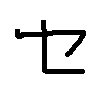

In [2]:
Image.open('data/images/Japanese_(katakana)/character13/0608_01.png')

the same alphabet in different variation

같은 알파벳의 변형된 데이터

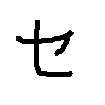

In [3]:
Image.open('data/images/Japanese_(katakana)/character13/0608_13.png')

Let us see sanskrit alphabet

산스크리트어 알파벳과 그 철자의 변형

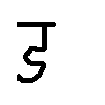

In [4]:
Image.open('data/images/Sanskrit/character13/0863_09.png')

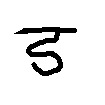

In [5]:
Image.open('data/images/Sanskrit/character13/0863_13.png')

How can we convert this image into an array? we can use np.array function to convert these images into an array and then we reshape it to 28*28

어떻게 하면 이 이미지를 배열로 변환할 수 있을까? np.array 기능을 사용하여 이러한 이미지를 배열로 변환한 다음 28\*28로 재구성할 수 있다

In [6]:
image_name = 'data/images/Sanskrit/character13/0863_13.png'
alphabet, character, rotation = 'Sanskrit/character13/rot000'.split('/')
rotation = float(rotation[3:])

In [7]:
np.array(Image.open(image_name).rotate(rotation).resize((28, 28)), np.float32,copy=True)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1

Now, that we have understood, what is in our dataset, let us load our dataset:

이제 데이터셋이 어떤 데이터가 있는지 파악했으므로 데이터셋을 로드해 봅시다.

In [8]:
root_dir = 'data/'

We have the splitting details in the /data/omniglot/splits/train.txt file which has the language name, character number, rotation information and images in /data/omniglot/data/ directory.

우리는 /data/omniglot/splits/train.txt 파일에 분할 세부사항이 있다.
이는 이미지, 언어 이름, 철자 번호, 회전 정보를 갖고 있다.

In [9]:
train_split_path = os.path.join(root_dir, 'splits', 'train.txt')

with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]

In [10]:
#number of classes
no_of_classes = len(train_classes)

Now we set the number of examples to 20, as we have 20 example per class in our dataset, and also we set image width and height to 28 x 28:

데이터 집합에 클래스당 20개의 예제가 있으므로 예제 수를 20개로 설정하고 이미지 너비와 높이를 28 x 28로 설정

In [11]:
#number of examples
num_examples = 20

#image width
img_width = 28

#image height
img_height = 28
channels = 1

Next, we initialize our training dataset with a shape as a number of classes, number of examples, image height and image width:

다음으로, 훈련 데이터 세트를 클래스, 예시 수, 이미지 높이 및 이미지 너비로 초기화하십시오.

In [12]:
train_dataset = np.zeros([no_of_classes, num_examples, img_height, img_width], dtype=np.float32)

Now, we read all the images, convert it to numpy array and store it our train_dataset array with their label and values, that is,  train_dataset = [label, values]:

이제 우리는 모든 이미지를 읽고, 그것을 numpy 행렬로 변환하여 train_dataset 행렬에 라벨과 값을 저장한다. 즉, train_dataset = [label, values]:

In [13]:
for label, name in enumerate(train_classes):
    alphabet, character, rotation = name.split('/')
    rotation = float(rotation[3:])
    img_dir = os.path.join(root_dir, 'data', alphabet, character)
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.png')))
  
    
    for index, img_file in enumerate(img_files):
        values = 1. - np.array(Image.open(img_file).rotate(rotation).resize((img_width, img_height)), np.float32, copy=False)
        train_dataset[label, index] = values

In [14]:
train_dataset.shape

(4112, 20, 28, 28)

Now that we have loaded our training data, we need to create embeddings for them. We generate the embeddings using a convolution operation as our inputs are images. So, we define a convolutional block with 64 filters with batch normalization and ReLU as the activation function. Followed by we perform max pooling operation:

이제 학습용 데이터에 임베딩도 만들어야 한다. 우리는 컨볼루션을 수행하여 이미지의 임베딩들을 생성한다. 그래서 우리는 64개의 필터로 구성된 배치 정규화와 ReLU를 활성화 함수로 정의한다. 다음으로 Max 풀링 작업을 수행한다.

In [15]:
def convolution_block(inputs, out_channels, name='conv'):

    conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
    conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
    conv = tf.nn.relu(conv)
    conv = tf.contrib.layers.max_pool2d(conv, 2)
    
    return conv

Now, we define our embedding function which gives us the embedding comprising of four convolutional blocks:

이제 네 개의 콘볼루션 블록으로 구성된 임베딩 기능을 정의한다.

In [16]:
def get_embeddings(support_set, h_dim, z_dim, reuse=False):

        net = convolution_block(support_set, h_dim)
        net = convolution_block(net, h_dim)
        net = convolution_block(net, h_dim) 
        net = convolution_block(net, z_dim) 
        net = tf.contrib.layers.flatten(net)
        
        return net

Remember, we don't use our whole dataset for training, since we are one shot learning, we sample some data points from each class as a support set and train the network using the support set in an episodic fashion. 


Now we define some of the important variables, we consider a 60-way 5-shot learning scenario:

기억해라. 우리는 전체 데이터 세트를 교육에 사용하지 않는다. 우리는 원샷 학습이기 때문에 각 클래스의 데이터 포인트를 support 세트로 샘플링하고 support 세트를 사용하여 네트워크를 학습시킨다.


이제 우리는 몇 가지 중요한 변수를 정의하고, 60-way 5-shot 학습 시나리오를 고려한다.

In [17]:
#number of classes
num_way = 60  

#number of examples per class for support set
num_shot = 5  

#number of query points
num_query = 5 

#number of examples
num_examples = 20

h_dim = 64

z_dim = 64

Next, we initialize placeholders for our support set and query set:

support 세트, query 세트를 위한 텐서 변수를 초기화 한다.

In [18]:
support_set = tf.placeholder(tf.float32, [None, None, img_height, img_width, channels])
query_set = tf.placeholder(tf.float32, [None, None, img_height, img_width, channels])

And we store the shape of our support set and query set in support_set_shape and query_set_shape respectively:

그리고 support_set_shape와 query_set_shape에 각각의 set_shape를 저장한다.

In [19]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)

Get the number of classes and number of data points in the support set and number of data points in the query set for initializing our support and query sets:

support 및 query 세트를 초기화할 수 있도록 support 세트의 클래스 및 데이터 포인트 수 및 query 세트 데이터 포인트 수를 확인하십시오.

In [20]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [21]:
num_query_points = query_set_shape[1]

Next, we define the placeholder for our label:

라벨데이터를 정의한다

In [22]:
y = tf.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)

Now, we generate the embeddings for our support set using our embedding function:

이제 임베딩 함수를 사용하여 지원 세트에 대한 임베딩 생성한다

In [23]:
support_set_embeddings = get_embeddings(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channels]), h_dim, z_dim)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use keras.layers.flatten instead.


We compute the prototype of each class which is the mean vector of the support set embeddings of the class:

우리는 각 클래스의 서포트 세트 임베딩의 평균 벡터 프로토타입을 계산한다.

In [24]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]

class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

Next, we use our same embedding function for getting embeddings of the query set:

다음으로, 우리는 query 세트의 임베딩에 동일한 임베딩 기능을 사용한다.

In [25]:
query_set_embeddings = get_embeddings(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channels]), h_dim, z_dim, reuse=True)

Now that, we have the class prototype and query set embeddings, we define a distance function which gives us the distance between the class prototypes and query set embeddings:

이제 클래스 프로토타입과 query 세트 임베딩이 있으므로, 클래스 프로토타입과 query 세트 임베딩 사이의 거리를 구하는 유클리드 거리 함수를 정의한다.

In [26]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)


Calculate the distance between the class prototype and query set embeddings:

클래스 프로토타입과 query 세트 임베딩 사이의 거리를 계산한다.

In [27]:
distance = euclidean_distance(class_prototype,query_set_embeddings)

Next, we get the probability for each class as a softmax to the distance:

다음으로, 각 클래스에 대한 확률을 거리에 대한 소프트맥스로 구한다.

In [28]:
predicted_probability = tf.reshape(tf.nn.log_softmax(-distance), [num_classes, num_query_points, -1])

Compute the loss

loss 계산

In [36]:
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

Calculate accuracy

정확도 계산

In [37]:
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(predicted_probability, axis=-1), y)))

We use Adam optimizer for minimizing the loss:



loss를 최소화 하기 위해 adam optimizer를 사용

In [38]:
train = tf.train.AdamOptimizer().minimize(loss)

Now, we start our tensorflow session and train the model,

In [39]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [40]:
num_epochs = 20
num_episodes = 100

In [ ]:
for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = train_dataset[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = train_dataset[class_, selected[num_shot:]]
            
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (episode+1) % 10 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 10 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 20 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 30 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 40 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 50 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 60 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 70 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 80 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 90 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 1 : Episode 100 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 2 : Episode 10 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 2 : Episode 20 : Loss: 5.703781604766846, Accuracy: 0.01666666753590107
Epoch 2 : Episode 30 : Loss: 5.703781604766846, Accuracy: 0.016